<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="https://mng.bz/lZ5B">Build a Reasoning Model (From Scratch)</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/reasoning-from-scratch">https://github.com/rasbt/reasoning-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="https://mng.bz/lZ5B"><img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Improving GRPO for Reinforcement Learning

Packages that are being used in this notebook:

In [1]:
from importlib.metadata import version

used_libraries = [
    "reasoning_from_scratch",
    "torch",
    "tokenizers"  # Used by reasoning_from_scratch
]

for lib in used_libraries:
    print(f"{lib} version: {version(lib)}")

reasoning_from_scratch version: 0.1.15
torch version: 2.10.0
tokenizers version: 0.22.2


<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F01_raschka.webp?1" width=600>

&nbsp;
## 7.1 Improving GRPO

- Note: you may skip this chapter if it is too technical and you are not interested in additional GRPO details; the next chapter does not depend on it

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F02_raschka.webp?1" width=400>

&nbsp;
## 7.2 Tracking GRPO performance metrics

- We ran a short RLVR training run in the previous chapter and briefly discussed the results

- For instance, in the previous section, we saw the outputs for a short run, which were structured as follows:

```
[Step 1/50] loss=-0.0000 reward_avg=0.000 avg_resp_len=5.5
[Step 2/50] loss=-0.0000 reward_avg=0.000 avg_resp_len=6.8
[Step 3/50] loss=0.3592 reward_avg=0.250 avg_resp_len=7.8
[Step 4/50] loss=2.7401 reward_avg=0.250 avg_resp_len=56.5
[Step 5/50] loss=3.3214 reward_avg=0.500 avg_resp_len=251.2
# ...
```

- In this section, we pick up where we left off and discuss some of the metrics to track when running RLVR

&nbsp;
### 7.2.1 Executing a GRPO training run

- The code in chapter 6 tries to strike a balance between showing the whole GRPO pipeline and being concise to improve readability
- The supplementary materials contain a script ([ch06/02_rlvr_grpo_scripts_intro
/rlvr_grpo_original_no_kl.py](https://github.com/rasbt/reasoning-from-scratch/blob/main/ch06/02_rlvr_grpo_scripts_intro/rlvr_grpo_original_no_kl.py)) with the same code, but may be more convenient to run from a code terminal
- In this chapter, we will be referencing scripts from the supplementary materials for convenience and to avoid excessive code duplication that would clutter the notebook and chapter
- Using the following helper function, we will download code from the supplementary materials and save it in our local directory throughout this chapter

In [2]:
from pathlib import Path
import requests

def download_from_github(rel_path, out=None):
    github_raw_base = (  # Base URL
        "https://raw.githubusercontent.com/rasbt/"
        "reasoning-from-scratch/refs/heads/main/"
    )

    rel_path = Path(rel_path)
    # Use URL file name as default output file name
    out = Path(out) if out is not None else Path(rel_path.name)

    # Skip download if file already exists locally
    if out.exists():
        size_kb = out.stat().st_size / 1e3
        print(f"{out}: {size_kb:.1f} KB (cached)")
        return out

    # Download file
    r = requests.get(github_raw_base + str(rel_path))
    r.raise_for_status()

    out.write_bytes(r.content)
    size_kb = out.stat().st_size / 1e3
    print(f"{out}: {size_kb:.1f} KB")

- Download GRPO script (based on code from chapter 6):

In [3]:
download_from_github(
    "ch06/02_rlvr_grpo_scripts_intro/rlvr_grpo_original_no_kl.py"
)

rlvr_grpo_original_no_kl.py: 13.7 KB (cached)


PosixPath('rlvr_grpo_original_no_kl.py')

- If the downloaded files have sizes much smaller than the ones shown above, there might have been something wrong with the download
- Please double-check if the URLs have been typed correctly
- Additionally, please see the [Troubleshooting Guide](https://github.com/rasbt/reasoning-from-scratch/blob/main/troubleshooting.md) if you continue having problems with the file download

- If you don't want to run the training code, which is reasonable, because it is relatively expensive, log files for the following run are provided in the supplementary materials for the following run (more info on how to download them later):


```bash
uv run rlvr_grpo_original_no_kl.py \
    --steps 500  \
    --max_new_tokens 1024
```

- I recommend running the script (using the command above) in the terminal, but it's also possible to run them in Jupyter notebooks in a code cell and by prepending an "!", i.e., `!uv run rlvr_grpo_original_no_kl.py`
- If you are not a `uv` user, replace `uv run` with `python`, i.e., `python rlvr_grpo_original_no_kl.py`

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F03_raschka.webp" width=600>

- As mentioned earlier, instead of reproducing the run above yourself, which can be expensive, you can download the log files as follows:

In [4]:
# Log file in plain text

download_from_github(
    "ch07/02_logs/ch06_rlvr_grpo_original_no_kl_metrics.txt"
)

# Same log file in CSV format
download_from_github(
    "ch07/02_logs/ch06_rlvr_grpo_original_no_kl_metrics.csv"
)

ch06_rlvr_grpo_original_no_kl_metrics.txt: 43.7 KB (cached)
ch06_rlvr_grpo_original_no_kl_metrics.csv: 25.1 KB (cached)


PosixPath('ch06_rlvr_grpo_original_no_kl_metrics.csv')

&nbsp;
### 7.2.2 Inspecting the GRPO training run

- We use the following utility functions to plot the results from the log files throughout this chapter

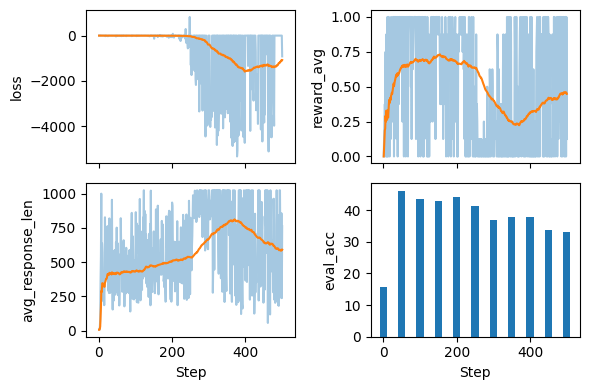

In [5]:
import csv
import matplotlib.pyplot as plt


def moving_average(values, window_fraction=0.25):
    # Smooth a noisy training signal to reveal longer-term trends during training
    window_size = max(1, int(window_fraction * len(values)))
    smoothed = []

    for i in range(len(values)):
        start_idx = max(0, i - window_size + 1)
        window_mean = sum(values[start_idx : i + 1]) / (i - start_idx + 1)
        smoothed.append(window_mean)

    return smoothed


def plot_grpo_metrics(csv_path, columns, save_as=None):
    data = {name: {"steps": [], "values": []} for name in columns}

    # Open and read CSV log file
    with Path(csv_path).open(newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if not row or not row.get("step"):
                continue

            # Use the training step as the shared x-axis across all metrics
            step = int(row["step"])

            for name in columns:
                value_str = row.get(name)
                if value_str:
                    data[name]["steps"].append(step)
                    data[name]["values"].append(float(value_str))

    # Create a fixed grid so loss, rewards, response length, etc. can be shown side by side
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(6, 4))
    axes = axes.ravel()

    for i, name in enumerate(columns):
        steps = data[name]["steps"]
        values = data[name]["values"]

        # Skip metrics that are not present
        if not values:
            fig.delaxes(axes[i])
            continue

        # Evaluation accuracy as barplot because we don't have data for each step
        if name == "eval_acc":
            axes[i].bar(steps, values, width=20)
        else:
            axes[i].plot(steps, values, alpha=0.4)
            axes[i].plot(steps, moving_average(values))

        axes[i].set_ylabel(name)

    for j in (2, 3):
        if axes[j] in fig.axes:
            axes[j].set_xlabel("Step")

    plt.tight_layout()
    if save_as is not None:
        plt.savefig(save_as)
    plt.show()


# Plot the GRPO training run
plot_grpo_metrics(
    "ch06_rlvr_grpo_original_no_kl_metrics.csv",
    columns=["loss", "reward_avg", "avg_response_len", "eval_acc"],
    # save_as="4.pdf"
)

- Here are some general observations and thoughts:
  - Average response length should initially go up (ideally with accuracy going up); this looks good overall, although we see some later decline just before step 400
  - Compared to pre-training, the loss is not very meaningful; it should stay relatively flat, but some fluctuations are ok (spikes toward the end are a bit concerning, though)
- Average rewards should go up; technically, an average reward of 1.00 means all answers are correct, which is great, but then we would have reached a point where there is no training signal anymore, and we should stop
- Target/external task performance (here: MATH-500 accuracy) should improve; it does that initially and then declines

- Summary: we have fast early gains, then diminishing returns
  - One reason is that the algorithm is not very stable 
  - (Another potential explanation could be that problems get harder, but then we wouldn't see the decline in evaluation accuracy)

- Note that we focus here on a simplified tracking of GRPO runs; the next section adds some more
- By the way, evaluation accuracy (here: MATH-500 accuracy) is not tracked by default
- It can be calculated on the 500 MATH-500 test examples during training by adding `--eval_on_checkpoint 500`, but this slows down the training
- Alternatively, it can be computed afterwards using the `evaluate_math500.py` script (containing the code from chapter 3)

In [6]:
download_from_github(
    "ch03/02_math500-verifier-scripts/evaluate_math500.py"
)

evaluate_math500.py: 3.5 KB (cached)


PosixPath('evaluate_math500.py')

- The evaluation can then be run as follows on a given checkpoint:

```bash
uv run evaluate_math500.py \
  --dataset_size 500 \
  --checkpoint_path \
    "checkpoints/rlvr_grpo_original_no_kl/\
qwen3-0.6B-rlvr-grpo-step00050.pth"
```

- I already added the results from these evaluation runs, for every 50th step, to the log file we analyzed previously

&nbsp;
## 7.3 Tracking more advanced GRPO performance metrics

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F05_raschka.webp" width=400>

- In the previous section, we looked at basic performance metrics to track GRPO runs
- There are several other useful metrics we could track
- Two examples include
  - the advantages that we already computed in the `compute_grpo_loss` function (chapter 6)
  - the entropy of the computed sequences

&nbsp;
### 7.3.1 Advantage tracking

- As part of the GRPO algorithm, we compute the so-called advantages as discussed previously (chapter 6)
- These advantages are also useful to analyze training dynamics

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F06_raschka.webp" width=400>

- In particular, we compute two new summary statistics derived from the advantages: the average value (as the sample `mean`) and standard deviation (`std`)

In [7]:
import torch

def compute_advantage_stats(rewards_list):
    # This is what we already compute in GRPO:
    rewards = torch.tensor(rewards_list)
    advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

    # These are the new statistics we add:
    adv_avg = advantages.mean().item()
    adv_std = advantages.std().item()

    return advantages, adv_avg, adv_std

- Below is an example using a small sample of four reward values (similar to the ones shown in the previous figure)

In [8]:
adv, adv_avg, adv_std = compute_advantage_stats([1., 1., 0., 0.])

print(f"Advantages: {adv}")
print(f"Advantage mean = {adv_avg:.4f}, std = {adv_std:.4f}")

Advantages: tensor([ 0.8659,  0.8659, -0.8659, -0.8659])
Advantage mean = 0.0000, std = 0.9998


- Mean:
  - Note that the way we compute the advantages, the mean will always be 0; in GRPO, it's just a sanity check that our code works as intended

- Std:
  - The standard deviation has more information here 
  - std ≈ 1 means we have a good scale of the gradient signal for stable updates
  - std ≪ 1 means vanishing signal (often happens when rewards collapse)
  - std ≫ 1 means overly spiky updates that can destabilize training

- Extreme cases are those where the rewards are all similar; in this case, the standard deviation is 0, and we can use it as a measure to detect the lack of a training signal

In [9]:
adv, adv_avg, adv_std = compute_advantage_stats([0., 0., 0., 0.])
print(f"Advantages: {adv}")
print(f"Advantage mean = {adv_avg:.4f}, std = {adv_std:.4f}")

Advantages: tensor([0., 0., 0., 0.])
Advantage mean = 0.0000, std = 0.0000


In [10]:
adv, adv_avg, adv_std = compute_advantage_stats([1., 1., 1., 1.])
print(f"Advantages: {adv}")
print(f"Advantage mean = {adv_avg:.4f}, std = {adv_std:.4f}")

Advantages: tensor([0., 0., 0., 0.])
Advantage mean = 0.0000, std = 0.0000


- In practice, it's best to look at advantage statistics together with reward averages, because, as mentioned before, a reward average of 1 is actually a good thing; we don't have a training signal anymore, but the model gets all answers correct
- At this point, we should either stop training or choose more difficult examples

&nbsp;
### 7.3.2 Entropy tracking

- Entropy measures how uncertain the LLM is when producing the next token
  - High entropy: The model spreads probability mass over many tokens (good for exploration)
  - Low entropy: The model puts almost all mass on one token (more deterministic behavior, could indicate possible collapse)

- Before calculating entropy, let's consider how we computed the log-probability values (logprobs) in chapter 5:

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F07_raschka.webp" width=600>

- Instead of using real logits created by prompting the base model, we use example logits assuming a vocabulary size of 7 (otherwise, with the original 151k vocabulary, things would be way too messy in the plot above)

In [11]:
# Toy logits
logits = torch.tensor([
    0.6667, -2.0000,  1.3333, -0.0000, -0.6667,  2.0000, -1.3333
])

- The code below implements the calculation from the previous figure:

In [12]:
logprobs = torch.log_softmax(logits, dim=-1)
print("All token logprobs:", logprobs)

# Index of the selected token
selected_token = torch.argmax(logprobs)

selected = logprobs[selected_token]
print("Selected token ID:", selected_token)
print("Selected token logprob:", selected)

All token logprobs: tensor([-2.0442, -4.7109, -1.3776, -2.7109, -3.3776, -0.7109, -4.0442])
Selected token ID: tensor(5)
Selected token logprob: tensor(-0.7109)


- The entropy is a related concept; we calculate it by multiplying the probability values by the log-probability values, then we sum these resulting products, as illustrated in the next figure
- In principle, one could also track simpler quantities such as the sum of probabilities or log-probabilities, but entropy is a well-established and interpretable measure of uncertainty in probability distributions

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F08_raschka.webp" width=400>

- Btw., as a rule of thumb:
  - Very low entropy (≈ 0–0.5) means one token dominates the distribution, where the model is highly confident and behaves almost deterministically
  - Moderate entropy (≈ 1–2) means that the probability mass is shared among a few more tokens, which is typical during stable training
  - High entropy (≫ 2, approaching log(vocabulary_size); here: log(7) = 1.9459), the probability mass is spread across many tokens, and the model is highly uncertain and behaves close to random

- We can calculate the entropy as follows:

In [13]:
# Probabilities from logits
probs = torch.softmax(logits, dim=-1)
logprobs = torch.log_softmax(logits, dim=-1)

# Entropy from probabilities
entropy = torch.sum(-(probs * logprobs))

print("Probs:", probs)
print("Entropy:", entropy)

Probs: tensor([0.1295, 0.0090, 0.2522, 0.0665, 0.0341, 0.4912, 0.0175])
Entropy: tensor(1.3700)


- Alternatively, if we only have log-probability values, we could convert the log-probability values back into probability values via `torch.exp`
- You can see that the values below match the "probs" values above:

In [14]:
print("Probs:", torch.exp(logprobs))

Probs: tensor([0.1295, 0.0090, 0.2522, 0.0665, 0.0341, 0.4912, 0.0175])


- Using this concept from above, we can upgrade the `sequence_logprob` function from the previous chapter to a `sequence_logprob_and_entropy` function that returns both logprobs and the entropy:

In [15]:
def sequence_logprob_and_entropy(model, token_ids, prompt_len):
    # Old: Code is identical to chapter 5
    logits = model(token_ids.unsqueeze(0)).squeeze(0).float()
    logprobs = torch.log_softmax(logits, dim=-1)

    targets = token_ids[1:]
    selected = logprobs[:-1].gather(1, targets.unsqueeze(-1)).squeeze(-1)

    # Log-prob of the generated answer tokens (sum over answer steps)
    selected_answer_logprobs = selected[prompt_len - 1:]
    logp_all_steps = torch.sum(selected_answer_logprobs)

    # New: Calculate entropy
    all_answer_logprobs = logprobs[:-1][prompt_len - 1:]
    if all_answer_logprobs.numel() == 0:  # Safeguard if the model immediately returns EOS token
        entropy_all_steps = logp_all_steps.new_tensor(0.0)
    else:
        all_answer_probs = torch.exp(all_answer_logprobs)  # convert logprob to prob
        plogp = all_answer_probs * all_answer_logprobs     # elementwise p * log p
        step_entropy = -torch.sum(plogp, dim=-1)           # sum over vocab -> entropy per step
        entropy_all_steps = torch.mean(step_entropy)       # average over answer steps

    return logp_all_steps, entropy_all_steps

- We can use this function inside the `compute_grpo_loss` function to also compute the entropy so that we can track it during training
- Note that the previous figure illustrated the entropy computation for a single token in the LLM's rollout (`step_entropy`); the `sequence_logprob_and_entropy` computes the entropy as the average entropy over all answer tokens: `entropy_all_steps = torch.mean(step_entropy)`
- For example, if we consider the answer `"this is the LLM response"`, the step entropy is the entropy of one token (like `"this"`), and the average entropy over all answer steps is the average entropy over all answer tokens `"this is the LLM response"`

&nbsp;
### 7.3.3 Plotting additional GRPO metrics

- Let's see this in action and analyze the advantage statistics and entropy for a training run
- To do this, we could replace `sequence_logprob_and_entropy` in the `compute_grpo_loss` and then print and track the entropy in the `train_rlvr_grpo` that uses the `compute_grpo_loss` function internally
- To avoid lengthy code duplication, the full, modified code is provided in the supplementary materials, and we can download it as follows:

In [16]:
download_from_github(
    "ch07/03_rlvr_grpo_scripts_advanced/7_3_plus_tracking.py"
)

7_3_plus_tracking.py: 15.1 KB (cached)


PosixPath('7_3_plus_tracking.py')

- The code can be run similarly to the training script we discussed previously:

```bash
uv run 7_3_plus_tracking.py \
    --steps 500  \
    --max_new_tokens 1024
```

- Since it takes a long time to train, the resulting CSV log file can be downloaded as follows:

In [17]:
download_from_github(
    "ch07/02_logs/7_3_plus_tracking_metrics.csv"
)

7_3_plus_tracking_metrics.csv: 39.0 KB (cached)


PosixPath('7_3_plus_tracking_metrics.csv')

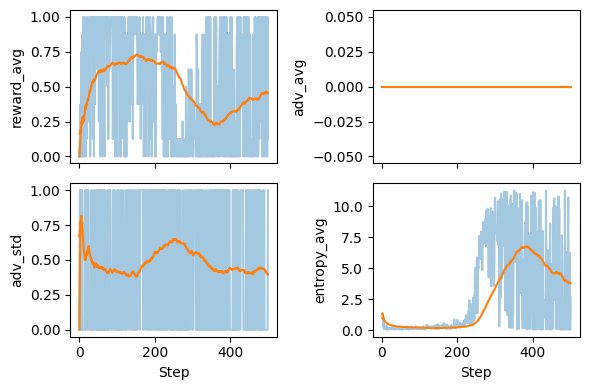

In [18]:
plot_grpo_metrics(
    "7_3_plus_tracking_metrics.csv",
    columns=["reward_avg", "adv_avg", "adv_std", "entropy_avg"],
    # save_as="9.pdf"
)

- The average advantage is and stays zero, which is exactly what we expect with GRPO-style normalization 
  - Advantages are computed relative to the group mean, so by construction, they should sum to zero
  - This metric is mostly a sanity check in GRPO, and if it drifted away from zero, that would point to a bug or other normalization bias issue
- The advantage std is the more informative signal
  - Early on, we see a relatively high variance, which means the model produces diverse rollouts 
  - Later on, the advantage std slowly declines and stabilizes, which means rollouts become more similar in quality
  - But the bottom line is that a nonzero (and stable) advantage std means there is still a usable learning signal

- Next, let’s look at the entropy
  - Early in training, the entropy is relatively flat and low (this indicates that the LLM is fairly deterministic)
  - In practice, increasing the sampling temperature would increase the output diversity during rollout, although it does not change the underlying LLM entropy
  - Later in training (after ~step 200), the entropy increases substantially, which means the next-token distribution is getting broader and the model is becoming more stochastic
  - Very low entropy can be a sign of collapse, where the model repeatedly produces the same or very similar outputs
  - In this run, however, considering entropy together with the reward average and the non-vanishing advantage standard deviation suggests an overall healthy exploration rather than collapse

- In short, individual metrics can tell us different things, but it is useful to look at these together in context

&nbsp;
## 7.4 Stabilizing sequence-level GRPO using clipped policy ratios

- So far, we mainly focused on analyzing the GRPO training results
- Next, we begin making additions to the GRPO algorithm
- The GRPO algorithm we have so far is a simplified version of GRPO, this section focuses on using a clipped policy ratio for the GRPO loss

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F10_raschka.webp" width=400>

&nbsp;
### 7.4.1 Computing clipped policy ratios

- The clipped policy ratio measures how much the current policy (the LLM being trained) differs from an earlier version of the same policy
- Concretely, it compares sequence log-probabilities computed before the update step with those computed after the update
- In the GRPO pipeline shown below, this corresponds to comparing the log-probabilities from step 4 (computed using the old parameters) with the log-probabilities produced by the updated model after step 6

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F11_raschka.webp?1" width=400>

- To recap, in the previous chapter, we computed the policy gradient loss as follows:

In [19]:
# Compute rollouts
# ...

# Compute rewards
rewards = torch.tensor([1., 1., 0., 0.])

# Compute sequence logprobs
logprobs = torch.tensor([-7.9243, -20.1546, -16.6130, -23.3677])

advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

pg_loss = -(advantages.detach() * logprobs).mean()
print("Policy gradient loss:", pg_loss)

Policy gradient loss: tensor(-2.5764)


- The clipped ratio is computed between logprobs from a previous policy (`old_logps`) and the current logprobs (`new_logps`)
- The derivation is outside the scope, but interested readers can find more information in the [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347) paper
- For illustration purposes, we use the logprobs from the example above as the `old_logps`, pretend we carried out a model update, and compute the `new_logps` with the updated model (we would use the same prompt here for the old and current policy to have an apples-to-apples comparison)

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F12_raschka.webp?2" width=600>

In [20]:
new_logps = logprobs

# The values of the new_logps
# are shown side by side in the comments
old_logps = torch.tensor([
    -10.9243,   # -7.9243
    -20.3546,   # -20.1546
    -14.6130,   # -16.6130
    -23.3677,   # -23.3677
])

log_ratio = new_logps - old_logps
ratio = torch.exp(log_ratio)
clip_eps = 10.0
clipped_ratio = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps)

print("Ratio:        ", ratio)
print("Clipped ratio:", clipped_ratio)

Ratio:         tensor([20.0855,  1.2214,  0.1353,  1.0000])
Clipped ratio: tensor([11.0000,  1.2214,  0.1353,  1.0000])


- The `ratio` tells us how different the old and new logprobs are; if they are the same, we see a 1.0
- The `clipped_ratio` enforces a maximum deviation from the old policy to ensure that updates remain relatively conservative and improve training stability
- In particular, it is common to clamp it to 1 +/- `clip_eps`; in DeepSeek-R1 training, clip_eps was set to 10, which means very weak clipping (however, in other RL training pipelines, it is not uncommon to set `clip_eps` to a much smaller value like 0.1)
  

- Next, we apply the `ratio` and `clipped_ratio` to the loss calculation
- Before, we multiplied the advantages and the logprobs directly
- Now, we scale the advantages by the policy ratios and use the clipped objective to limit how much each rollout can influence the update

In [21]:
# Treat advantages as fixed learning signals (no backprop through rewards)
adv = advantages.detach()

unclipped = ratio * adv
clipped = clipped_ratio * adv

# PPO-style clipping
obj = torch.where(
    adv >= 0,
    torch.minimum(unclipped, clipped),  # cap large positive updates
    torch.maximum(unclipped, clipped),  # cap large negative updates
)
    
clipped_pg_loss = -torch.mean(obj)
policy_ratio = torch.mean(ratio)

print("Clipped policy gradient loss:", clipped_pg_loss)
print("Policy ratio:", policy_ratio)

Clipped policy gradient loss: tensor(-2.3998)
Policy ratio: tensor(5.6106)


- The large policy ratio in this example means that the updated policy (model) assigns a much higher probability to the sampled tokens than the previous policy
- Note that the clipped policy gradient loss (-2.3998) is now slightly lower than the regular policy gradient loss (-2.5764) we computed before, which means that the model weight update is slightly lower than before
- This clipping can prevent overly aggressive updates that could destabilize training

&nbsp;
### 7.4.2 Training with clipped policy ratios

- A script with the updated GRPO training that now implements the clipped policy ratio computation can be downloaded from the supplementary materials:

In [22]:
download_from_github(
    "ch07/03_rlvr_grpo_scripts_advanced/7_4_plus_clip_ratio.py"
)

7_4_plus_clip_ratio.py: 17.2 KB (cached)


PosixPath('7_4_plus_clip_ratio.py')

- Similar to before, we can run it as follows:

```bash
uv run 7_4_plus_clip_ratio.py \
    --steps 500  \
    --max_new_tokens 1024
```

- DeepSeek-R1 generates a large pool of rollouts (8,192) and splits them into 16 minibatches, then does one inner epoch over those minibatches
- Concretely, the approach is as follows:
  1. Make a copy of the current model as the reference policy
  2. Sample a big rollout pool using the reference policy
  3. Split those fixed rollouts into minibatches
  4. For each minibatch:
      - compute `old_logps` under the reference model
      - compute `new_logps` under the current model (which changes after each minibatch update)
      - update the current model
  5. Update the reference model

- Due to resource constraints, we can't generate that many rollouts and minibatches and have to use workarounds
1. We make a copy of the current model as the reference policy
2. We sample 8 rollouts using the reference policy
3. Then we compute:
  - `old_logps` under the reference model
  - `new_logps` under the current model
  - update the current model
4. The steps 2 and 3 are repeated with different rollouts, instead of using minibatches
5. Update the reference model

- In short, DeepSeek-R1 generates a huge rollout pool once, and then walk through it in minibatches
- In our code we generate a small batch of rollouts multiple times

- A log file of this run can be downloaded and visualized as follows:

In [23]:
download_from_github(
    "ch07/02_logs/7_4_plus_clip_ratio_metrics.csv",
)

7_4_plus_clip_ratio_metrics.csv: 42.7 KB (cached)


PosixPath('7_4_plus_clip_ratio_metrics.csv')

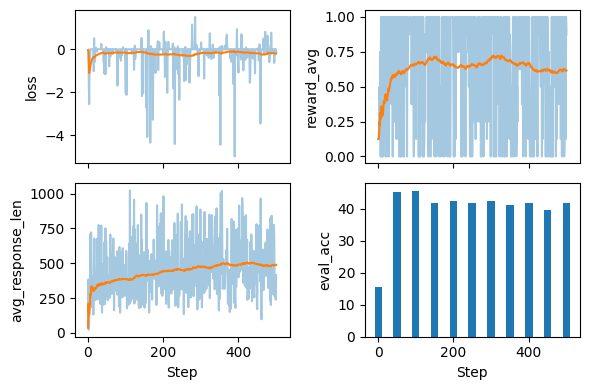

In [24]:
plot_grpo_metrics(
    "7_4_plus_clip_ratio_metrics.csv",
    columns=["loss", "reward_avg", "avg_response_len", "eval_acc"],
    save_as="13_1.pdf"
)

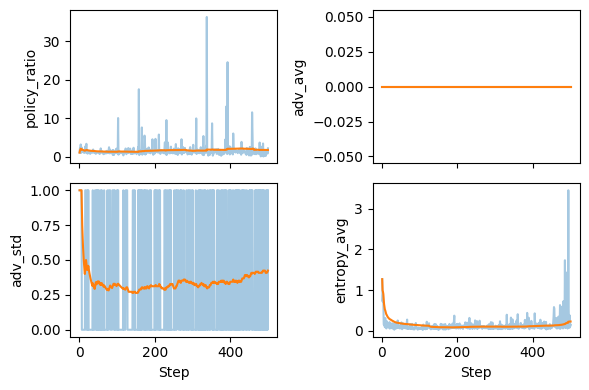

In [25]:
plot_grpo_metrics(
    "7_4_plus_clip_ratio_metrics.csv",
    columns=["policy_ratio", "adv_avg", "adv_std", "entropy_avg"],
    save_as="13_2.pdf"
)

- Based on the plots above, we can see that the training is now more stable than before, as there is no drop around step 400 anymore

&nbsp;
## 7.5 Controlling how much the model changes with a KL term

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F14_raschka.webp?2" width=400>

- In the previous chapter, we skipped the KL loss term of the GRPO algorithm, as it was already a very long chapter
- Readers familiar with RL algorithms may recognize that we essentially implemented [REINFORCE](https://en.wikipedia.org/wiki/Policy_gradient_method#REINFORCE) with group-normalized advantages
- To complete the GRPO algorithm, we now add the KL loss term
- KL is short for Kullback-Leibler divergence and measures how the current policy (the LLM we are training) deviates from a reference policy (the original LLM at the start of training)
- It acts as a regularizer that discourages overly large policy updates, which helps keep the model close to its original behavior and prevents drastic and unstable updates
- This is not unrelated to the clipped policy ratios we implemented previously; before we focused only on the size of the update steps, and now we explicitly minimize long-term drift

&nbsp;
### 7.5.1 Implementing the KL loss term

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F15_raschka.webp?2" width=400>

- For each rollout, we compute log-probabilities under both the current policy (model) and a fixed reference model, using the exact same generated tokens, as shown on the right side of the figure
- The KL divergence is then computed by summing the differences between these corresponding log-probabilities, which quantifies how much the current policy has shifted relative to the reference
- This KL term is added to the policy gradient loss, so weight updates that increase reward but also strongly increase the difference (divergence) from the reference model are penalized during training
- The reference model here is the original model before we start training (in DeepSeek-R1, this reference model is updated every 400 steps with the most recent model)

- To avoid code duplication, the code below does not show the full modified `compute_grpo_loss_with_kl`, which focuses only on the changes we have to make to the `compute_grpo_loss` function
- The new parts are those either highlighted by `"# New"` and those under `if kl_coeff`:

In [26]:
import copy

# kl_coeff = 0.0 deactivates the KL term and the code is similar to before
kl_coeff = 0.0  

# Make copy of the original model and disable gradients so it isn't updated
if kl_coeff:
    ref_model = copy.deepcopy(model).to(device)  # noqa: F821
    ref_model.eval()
    for p in ref_model.parameters():
        p.requires_grad = False
else:
    ref_model = None


def compute_grpo_loss_with_kl(
    model,
    ref_model,  # New
    # ...
    kl_coeff=0.02,  # New
):
    roll_logps, roll_ref_logps, roll_rewards, samples = [], [], [], []  # noqa: F841
    # ...

    for _ in range(num_rollouts):  # noqa: F821
        token_ids, prompt_len, text = sample_response(  # noqa: F821
        # ...
        )

        # Compute logprobs with reference model
        if kl_coeff:
            with torch.no_grad():
                ref_logp = sequence_logprob(  # noqa: F821
                    ref_model, token_ids, prompt_len
                )
        else:
            ref_logp = None

        reward = reward_rlvr(text, example["answer"])  # noqa: F821

        roll_rewards.append(reward)
        roll_logps.append(logp)  # noqa: F821
        if kl_coeff:
            roll_ref_logps.append(ref_logp)
        
        # ...

    rewards = torch.tensor(roll_rewards, device=device)  # noqa: F841
    advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

    logps = torch.stack(roll_logps)
    if kl_coeff:
        ref_logps = torch.stack(roll_ref_logps).detach()

    pg_loss = -(advantages.detach() * logps).mean()

    # Compute KL loss term
    if kl_coeff:
        kl_loss = kl_coeff * torch.mean(logps - ref_logps)
    else:
        kl_loss = torch.tensor(0.0, device=logps.device)

    # Add KL loss term to policy gradient loss
    loss = pg_loss + kl_loss  # noqa: F841

- Note that adding the KL loss term adds additional resource requirements, as we now have to keep an additional copy of the original model around
- The larger the `kl_coeff`, the stronger the divergence penalty

&nbsp;
### 7.5.2 Training with a KL loss term

- We can download the full script from the supplementary materials as follows

In [27]:
download_from_github(
    "ch07/03_rlvr_grpo_scripts_advanced/7_5_plus_kl.py"
)

7_5_plus_kl.py: 18.8 KB (cached)


PosixPath('7_5_plus_kl.py')

- Similar to before, we can run it as follows:

```bash
uv run 7_5_plus_kl.py \
    --steps 500  \
    --max_new_tokens 1024
```

- Similar to before, we can download the following log file for analysis, as running the experiment can be resource-intensive and expensive:

In [28]:
download_from_github(
    "ch07/02_logs/"
    "7_5_plus_kl_metrics.csv"
)

7_5_plus_kl_metrics.csv: 48.8 KB (cached)


PosixPath('7_5_plus_kl_metrics.csv')

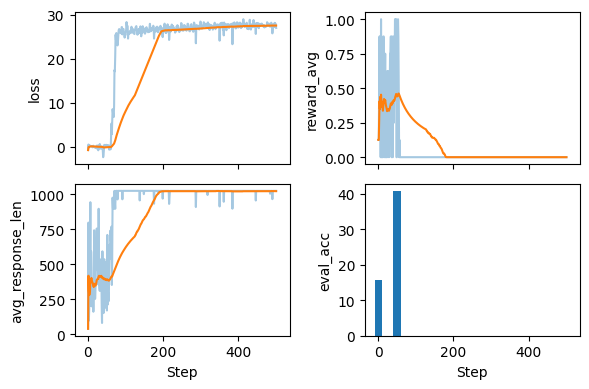

In [29]:
plot_grpo_metrics(
    "7_5_plus_kl_metrics.csv",
    columns=["loss", "reward_avg", "avg_response_len", "eval_acc"],
    # save_as="16.pdf"
)

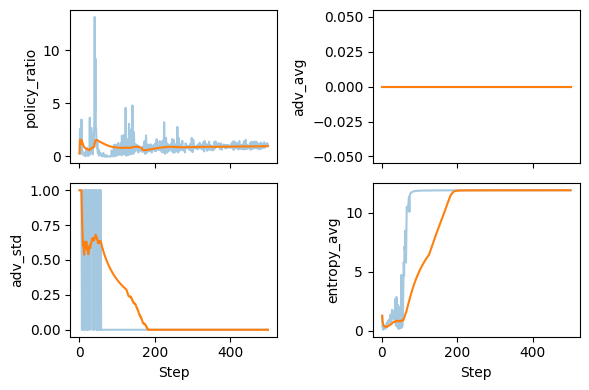

In [30]:
plot_grpo_metrics(
    "7_5_plus_kl_metrics.csv",
    columns=["policy_ratio", "adv_avg", "adv_std", "entropy_avg"],
)

- We can see that the training run falls apart shortly after 50 steps, and the evaluation accuracy goes toward 0
- Manual checking of the generated model responses reveals that the model starts outputting non-sensical text and random tokens like `"framework.raises Self profess(import"`
- This can have multiple reasons:
1. KL term is computed on summed logprobs
   - `kl_loss = kl_coeff * mean(new_logps - ref_logps)`, where `new_logps` and `ref_logps` are sums over answer tokens
   - So, longer sequences make the KL term grow in magnitude, which can incentivize very long outputs (as we can see based on the growing response length) and destabilize training
2. Once rewards collapse around step 200, KL becomes the only gradient
   - When rewards are all zero, advantages become 0, so the policy gradient loss has no gradient
   - However, the KL term is still there and then dominates updates and can push the model toward higher entropy / near-uniform distributions, which explains the randomness in the generated answers (and th 0.0% evaluation accuracy)

- While the KL term is a standard component of GRPO, which is why we introduce it here, several researchers found that the model may train better without, e.g.,
  - [Dr. GRPO](https://arxiv.org/abs/2503.20783)
  - [Olmo 3](https://arxiv.org/abs/2512.13961)
  - [DeepSeek V3.2](https://arxiv.org/abs/2512.02556)

Alternatively, we could stabilize the training in different ways

1. Length-normalize log-probs and KL using token-level logprobs
   - To use token-level logprobs we divide by generated length before the policy ratio and KL term computation
   - This removes incentives to inflate sequence length.

2. Lower the `kl_coeff` (e.g., to 0.001, but I found that this also doesn't help here)
       
3. Use a reweighted KL term (importance sampling)
   - Old: `kl_loss = kl_coeff * torch.mean(logps - ref_logps)`
   - New: `kl_loss = kl_coeff * torch.mean(torch.exp(new_logps - old_logps) * (new_logps - ref_logps))`

4. Add a small format reward to prevent advantages collapsing to zero; we will talk about format rewards in the next section

- However, as mentioned before, the common recommendation is not to use a KL term when training on math data (as recommended by Dr. GRPO, Olmo 3, and DeepSeek V3.2)
  - This also simplifies the code complexity and resource requirements

&nbsp;
## 7.6 Adding an explicit format reward

- So far, we only used a single correctness reward; in this section, we add a second format reward, similar to what DeepSeek-R1 did

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F17_raschka.webp?1" width=400>

&nbsp;
### 7.6.1 Using `<think>` tokens

- Some reasoning models (like DeepSeek-R1 and Qwen3) use so-called `<think>` `</think>` tokens
- This is not necessary, but can be useful to encourage the model to separate its intermediate reasoning from the final answer and enforce a consistent output structure
- Let's load the tokenizer of the base model we used previously:

In [31]:
from reasoning_from_scratch.ch02 import get_device
from reasoning_from_scratch.ch03 import load_model_and_tokenizer

device = get_device()
model, tokenizer_base = load_model_and_tokenizer(
    which_model="base",
    device=device,
    use_compile=False
)

Using Apple Silicon GPU (MPS)
✓ qwen3/qwen3-0.6B-base.pth already up-to-date


- As we can see, it breaks up the `<think>` token into several subword tokens, which indicates that the `<think>` token is not part of the vocabulary:

In [32]:
print(tokenizer_base.encode("<think>"))

[13708, 766, 29]


In [33]:
for i in [13708, 766, 29]:
    print(tokenizer_base.decode([i]))

<th
ink
>


- The tokenizer has some empty placeholder slots, so we could add the `<think>` token to the vocabulary as follows:

In [34]:
tokenizer_base._tok.add_special_tokens(
    ["<tool_response>", "</tool_response>", "<think>", "</think>"]
)

4

In [35]:
print(tokenizer_base.encode("<think>"))

[151667]


In [36]:
print(tokenizer_base.encode("</think>"))

[151668]


- We added the `"<tool_response>"` and `"</tool_response>"` tokens above to match it up with the tokenizer of the Qwen3 reasoning variant, which we will discuss shortly

- These tokens would also be supported by the model, which supports token IDs from 0 to 151935 as it has a vocabulary size of 151936

In [37]:
print("Vocabulary size:", model.tok_emb.weight.shape[0])

Vocabulary size: 151936


- Alternatively, the tokenizer of the reasoning model variant already supports these `<think>` tokens natively

- Similar to what we have done in chapter 2, we can load the tokenizer separately:

In [38]:
from reasoning_from_scratch.qwen3 import Qwen3Tokenizer
from reasoning_from_scratch.qwen3 import download_qwen3_small

download_qwen3_small(
    kind="reasoning", tokenizer_only=True, out_dir="qwen3"
)

tokenizer_path = Path("qwen3") / "tokenizer-reasoning.json"
tokenizer = Qwen3Tokenizer(tokenizer_file_path=tokenizer_path)

✓ qwen3/tokenizer-reasoning.json already up-to-date


In [39]:
print(tokenizer.encode("<think>"))

[151667]


In [40]:
print(tokenizer.encode("</think>"))

[151668]


- We can then develop a reward function that checks whether the LLM uses `<think>` `</think>` tags
- The function returns 1.0 if both `<think>` and `</think>` occur in the output and in the right order; otherwise, it returns 0.0

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F18_raschka.webp?1" width=600>

In [41]:
def reward_format(
    token_ids,
    prompt_len,
    start_think_id=151667,
    end_think_id=151668,
):
    try:
        gen = token_ids[prompt_len:].tolist()
        return float(
            gen.index(start_think_id) < gen.index(end_think_id)
        )
    except ValueError:
        return 0.0

In [42]:
prompt = "Calculate ..."
rollout = "Let's ... <think> ... </think> ..."
token_ids = tokenizer.encode(prompt + rollout)

reward_format(
    token_ids=torch.tensor(token_ids),
    prompt_len=len(tokenizer.encode(prompt))
)

1.0

- We can then use the format reward as an additional reward signal to train the model
- For instance, we could modify the `compute_grpo_loss` to a `compute_grpo_loss_plus_format_reward` function as follows:

In [43]:
def compute_grpo_loss_plus_format_reward(
    # ...
    format_reward_weight=1.0,  # NEW
):
    # ...

        logp = sequence_logprob(model, token_ids, prompt_len)  # noqa: F821, F841
        rlvr_reward = reward_rlvr(text, example["answer"])  # noqa: F821
        format_reward = reward_format(token_ids, prompt_len)         # NEW  # noqa: F821
        reward = rlvr_reward + format_reward_weight * format_reward  # NEW  # noqa: F841

    # ...

- In addition, we want to modify the `render_prompt` to direct the model to emit these `<think>` tokens:

In [44]:
def render_prompt_with_think_tokens(prompt):
    template = (
        "You are a helpful math assistant.\n"
        "When solving the problem, first write your reasoning inside <think> and </think> tags.\n"
        "Then write the final result on a new line in the exact format:\n"
        "\\boxed{ANSWER}\n\n"
        f"Question:\n{prompt}\n\nAnswer:"
    )
    return template

&nbsp;
### 7.6.2 Training a model to emit `<think>` tokens

- We can download the modified script from the supplementary materials as follows:

In [45]:
download_from_github(
    "ch07/03_rlvr_grpo_scripts_advanced/7_6_plus_format_reward.py"
)

7_6_plus_format_reward.py: 21.2 KB (cached)


PosixPath('7_6_plus_format_reward.py')

- If we train the base model with GRPO to emit `<think>` tokens, the results would be quite poor because the base model has never seen `<think>` tokens before
- Instead, we would want to pre-train or instruction fine-tune the model on data that includes `<think>` tokens first (instruction fine-tuning is covered in the next chapter)
- So, for this section, we train the existing "reasoning" variant of the model, which is already familiar with `<think>` tokens

- Similar to before, we can run it as follows (note that this script is already configured to use the "reasoning" model variant instead of the "base" model):

```bash
uv run 7_6_plus_format_reward.py \
    --steps 500  \
    --max_new_tokens 1024
```

- Also similar to before, we can download the following log file for analysis, as running the experiment can be resource-intensive and expensive:

In [46]:
download_from_github(
    "ch07/02_logs/7_6_plus_format_reward_metrics.csv"
)

7_6_plus_format_reward_metrics.csv: 51.7 KB (cached)


PosixPath('7_6_plus_format_reward_metrics.csv')

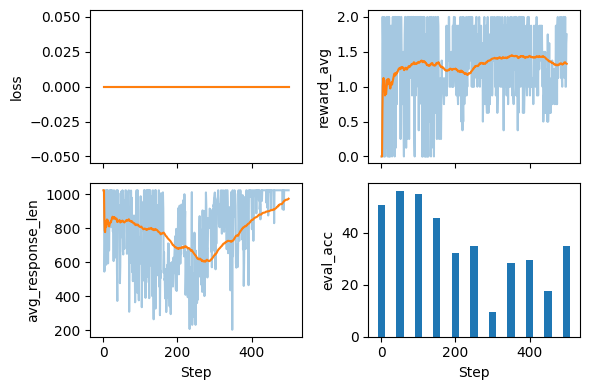

In [47]:
plot_grpo_metrics(
    "7_6_plus_format_reward_metrics.csv",
    columns=["loss", "reward_avg", "avg_response_len", "eval_acc"],
    #save_as="18.pdf"
)

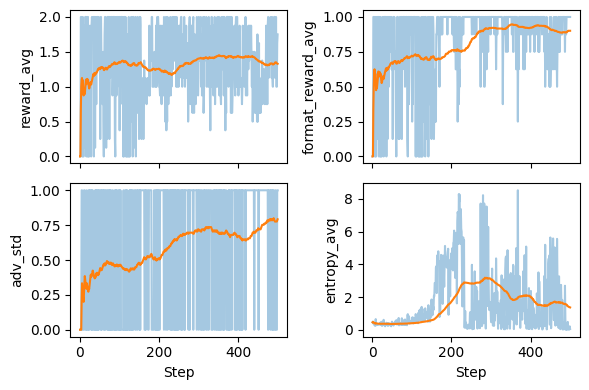

In [48]:
plot_grpo_metrics(
    "7_6_plus_format_reward_metrics.csv",
    columns=["reward_avg", "format_reward_avg", "adv_std", "entropy_avg"],
    #save_as="19.pdf"
)

- As we can see, the model initially improves but then becomes worse after the first 100 steps; this could be correlated to the shorter response length the model is outputting after these first 100 steps
- One potential explanation is that the model already gets too many rewards from following the `<think>` tag format, as shown above, and does not focus enough on the correctness anymore
- We could reduce the format reward magnitude by reducing the default `format_reward_weight` from 1.0 to 0.1
- Another improvement could be to make the format reward conditional, meaning that it is only awarded if the answer is also correct (right now, it is awarded independently of whether the answer is correct or not)

```python
if conditional_reward:
    format_reward *= rlvr_reward
reward = rlvr_reward + format_reward_weight * format_reward
```

&nbsp;
## 7.7 More GRPO modifications, tips, and tricks

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch07/CH07_F21_raschka.webp?3" width=400>

- In the months following the success of DeepSeek-R1, many researchers proposed improvements over the original GRPO algorithm that improve both the stability and performance
- Due to the already long length of this chapter, this section only briefly lists each change / improvement
- You can find more information and code on these in the [supplementary materials](../03_rlvr_grpo_scripts_advanced/)

1. Zero gradient signal filtering ([DAPO by Yu et al., 2025](https://arxiv.org/abs/2503.14476))
2. Active sampling (DAPO)
3. Token-level loss (DAPO)
4. No KL loss (DAPO and [Dr. GRPO by Liu et al., 2025](https://arxiv.org/abs/2503.20783))
5. Clip higher (DAPO)
6. Truncated importance sampling ([Yao et al., 2025](https://fengyao.notion.site/off-policy-rl))
7. No standard deviation normalization (Dr. GRPO)
8. KL tuning with domain-specific KL strengths; zero for math ([DeepSeek V3.2](https://arxiv.org/abs/2512.02556)
9. Reweighted KL (DeepSeek V3.2)
10. Off-policy sequence masking (DeepSeek V3.2)
11. Keep sampling mask for top-p / top-k (DeepSeek V3.2)
12. Keep original GRPO advantage normalization (DeepSeek V3.2)
13. Per-reward group-wise normalization before aggregation ([GDPO by Liu et al., 2026](https://arxiv.org/abs/2601.05242))
14. Sequence-level importance sampling and clipping ([GSPO by Zheng et al., 2025](https://arxiv.org/abs/2507.18071))
15. Clip importance-sampling weights rather than token updates ([CISPO by MiniMax et al., 2025](https://arxiv.org/abs/2506.13585))

&nbsp;
## 7.8 Summary

- No code in this section